In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SameConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1):
        super(SameConv1d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.dilation = dilation
        self.conv = nn.Conv1d(
            in_channels, 
            out_channels, 
            kernel_size=kernel_size, 
            stride=stride, 
            padding=0,  # padding은 수동으로 적용
            dilation=dilation
        )

    def forward(self, x):
        input_size = x.size(-1)

        # 패딩 계산
        total_padding = max(
            0,
            (input_size - 1) * self.stride + self.dilation * (self.kernel_size - 1) + 1 - input_size
        )
        left_padding = total_padding // 2
        right_padding = total_padding - left_padding

        # 비대칭 패딩 적용
        x = F.pad(x, (left_padding, right_padding))
        print(x)

        # Convolution 적용
        return self.conv(x)


In [27]:
# 입력 데이터: Batch size=1, Channels=1, Length=10
x = torch.randn(1, 1, 10)

# 'same' 패딩 Convolution
conv = SameConv1d(in_channels=1, out_channels=5, kernel_size=2, stride=4)

output = conv(x)
print(f"Input size: {x.shape}, Output size: {output.shape}")

print(x)
print(output)

tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.7394, -0.0121, -0.5791, -1.3157, -0.5678, -0.7415,  2.7017,
           0.8354, -0.3386,  0.1396,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]]])
Input size: torch.Size([1, 1, 10]), Output size: torch.Size([1, 5, 10])
tensor([[[ 0.7394, -0.0121, -0.5791, -1.3157, -0.5678, -0.7415,  2.7017,
           0.8354, -0.3386,  0.1396]]])
tensor([[[-0.4368, -0.4368, -0.4368, -0.4368,  0.1561,  0.3450, -0.4368,
          -0.4368, -0.4368, -0.4368],
         [ 0.2088,  0.2088,  0.2088,  0.2088,  0.0764, -0.2697,  0.2088,
           0.2088,  0.2088,  0.2088],
         [ 0.1693,  0.1693,  0.1693,  0.1693, -0.1710,  0.7440,  0.1693,
           0.1693,  0.1693,  0.1693],
         [-0.5284, -0.5284, -0.5284, -0.5284, -0.0797, -0.8991, -0.5284,
    

In [18]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F

class ConvBnRelu(nn.Module):
    def __init__(self,
                 ch_in: int,
                 ch_out: int,
                 kernel: int,
                 stride: int,
                 is_max_pool: bool,
                 dilation: int = 1,
                 padding: str = "no",
                 activation: str = 'relu') -> None:
        super().__init__()
        self.conv = nn.Conv1d(ch_in, ch_out, kernel, stride, 
                              padding=0, bias=False)
        self.bn = nn.BatchNorm1d(ch_out)

        self.activation = None        
        if activation.lower() == 'relu':
            self.activation = nn.ReLU()

        self.max_pool = nn.MaxPool1d(kernel_size=2, stride=2)

        self.kernel = kernel
        self.stride = stride        
        self.dilation = dilation
        self.is_max_pool = is_max_pool
        self.padding = padding
        
    def forward(self, feat_in: Tensor) -> Tensor:
        if self.padding == 'same':
            feat_in = self.pad_for_same_size(feat_in, self.kernel, self.stride, self.dilation)

        f_map = self.conv(feat_in)
        f_map = self.bn(f_map)
        if self.activation is not None:
            f_map = self.activation(f_map)

        if self.is_max_pool:
            f_map = self.max_pool(f_map)

        return f_map
    
    @staticmethod
    def pad_for_same_size(x, kernel_size, stride, dilation):
        input_size = x.size(-1)

        total_padding = max(
            0,
            (input_size - 1) * stride + dilation * (kernel_size - 1) + 1 - input_size
        )
        left_padding = total_padding // 2
        right_padding = total_padding - left_padding

        # 비대칭 패딩 적용
        x_padded = F.pad(x, (left_padding, right_padding))
        return x_padded

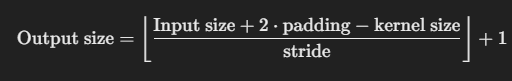

In [31]:
# 입력 데이터: Batch size=1, Channels=1, Length=10
x = torch.randn(1, 1, 3305831)

# 'same' 패딩 Convolution
conv_list = [
    ConvBnRelu(1, 8, 15, 5, is_max_pool=False),
    ConvBnRelu(8, 8, 15, 5, is_max_pool=False),

    ConvBnRelu(8, 8, 10, 3, is_max_pool=False), 
    ConvBnRelu(8, 8, 10, 3, is_max_pool=False), 

    ConvBnRelu(8, 8, 5, 2, is_max_pool=False),
    ConvBnRelu(8, 8, 5, 2, is_max_pool=False),

    ConvBnRelu(8, 16, 2, 2, is_max_pool=False),
    ConvBnRelu(16, 32, 2, 2, is_max_pool=False),
    ConvBnRelu(32, 64, 2, 2, is_max_pool=False),
    ConvBnRelu(64, 64, 2, 2, is_max_pool=False),
]

output = x

for _conv in conv_list:
    output = _conv(output)
    print(f" Output size: {output.shape}")

# print(x)
# print(output)

 Output size: torch.Size([1, 8, 661164])
 Output size: torch.Size([1, 8, 132230])
 Output size: torch.Size([1, 8, 44074])
 Output size: torch.Size([1, 8, 14689])
 Output size: torch.Size([1, 8, 7343])
 Output size: torch.Size([1, 8, 3670])
 Output size: torch.Size([1, 16, 1835])
 Output size: torch.Size([1, 32, 917])
 Output size: torch.Size([1, 64, 458])
 Output size: torch.Size([1, 64, 229])


In [1]:
import torch
from my_model import SimpleSleepPPGModel
from torchsummary import summary

device = torch.device("cuda")
net = SimpleSleepPPGModel().to(device)
model = net.cuda()
summary(net, (1, 3305831))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 8, 661164]             120
       BatchNorm1d-2            [-1, 8, 661164]              16
              ReLU-3            [-1, 8, 661164]               0
        ConvBnRelu-4            [-1, 8, 661164]               0
            Conv1d-5            [-1, 8, 132230]             960
       BatchNorm1d-6            [-1, 8, 132230]              16
              ReLU-7            [-1, 8, 132230]               0
        ConvBnRelu-8            [-1, 8, 132230]               0
            Conv1d-9             [-1, 8, 44074]             640
      BatchNorm1d-10             [-1, 8, 44074]              16
             ReLU-11             [-1, 8, 44074]               0
       ConvBnRelu-12             [-1, 8, 44074]               0
           Conv1d-13             [-1, 8, 14689]             640
      BatchNorm1d-14             [-1, 8